# <center> Project 2 - Classification of Wind Turbine Alarms </center>

## <center> MSDS 7331 Data Mining - Section 401 - Project 2 </center> 
### <center> Team:  Sarah Fite, Sheri Loftin, Casey Martinez, Kyle Thomas </center>




In [45]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
# import sklearn
import seaborn as sns
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
%matplotlib inline
# import pylab
# from scipy.optimize import curve_fit
# from sklearn import svm
# from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import Imputer
# from sklearn import preprocessing
# from sklearn.linear_model import LogisticRegression
# from sklearn import metrics as mt
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.model_selection import ShuffleSplit
# from sklearn.model_selection import cross_val_score
# import matplotlib as mpl
# pd.show_versions()

To start, we will first look at the alarm data and one quarter worth of wind farm supervisory control and data acquisition (SCADA) system data.  This SCADA data is specifically used for performance monitoring of large utility-scale wind turbines.

In [46]:
# path = '~/Documents/thomaskh522@gmail.com/SMU/DataMining/MiniProject/Data/'
path = 'D:/Pattern/'
alarms_desc = pd.read_csv(path + "Siemens_Fault_Code_Descriptions.csv")
scada = pd.read_csv(path + "SCADAcombined2017_T014.csv")

# drop columns that were missing values
scada.dropna(thresh=10000,axis=1,inplace=True)

print('alarm description shape:',alarms_desc.shape)
print('scada data shape:',scada.shape)

alarm description shape: (2141, 3)
scada data shape: (52462, 689)


### Cleaning the Data

Next, we dropped missing values from our dataset, removed unused columns, and reduce the data set to only one turbine.

In [47]:
list(scada.columns)

['TimeStamp',
 'StationId',
 'wtc_VoltPhR_min',
 'wtc_VoltPhR_max',
 'wtc_VoltPhR_mean',
 'wtc_VoltPhR_stddev',
 'wtc_VoltPhS_min',
 'wtc_VoltPhS_max',
 'wtc_VoltPhS_mean',
 'wtc_VoltPhS_stddev',
 'wtc_VoltPhT_min',
 'wtc_VoltPhT_max',
 'wtc_VoltPhT_mean',
 'wtc_VoltPhT_stddev',
 'wtc_ActPower_min',
 'wtc_ActPower_max',
 'wtc_ActPower_mean',
 'wtc_ActPower_stddev',
 'wtc_AmpPhR_min',
 'wtc_AmpPhR_max',
 'wtc_AmpPhR_mean',
 'wtc_AmpPhR_stddev',
 'wtc_AmpPhS_min',
 'wtc_AmpPhS_max',
 'wtc_AmpPhS_mean',
 'wtc_AmpPhS_stddev',
 'wtc_AmpPhT_min',
 'wtc_AmpPhT_max',
 'wtc_AmpPhT_mean',
 'wtc_AmpPhT_stddev',
 'wtc_CosPhi_min',
 'wtc_CosPhi_max',
 'wtc_CosPhi_mean',
 'wtc_CosPhi_stddev',
 'wtc_GridFreq_min',
 'wtc_GridFreq_max',
 'wtc_GridFreq_mean',
 'wtc_GridFreq_stddev',
 'wtc_ReactPwr_min',
 'wtc_ReactPwr_max',
 'wtc_ReactPwr_mean',
 'wtc_ReactPwr_stddev',
 'wtc_ActRegSt_endvalue',
 'wtc_RawPower_min',
 'wtc_RawPower_max',
 'wtc_RawPower_mean',
 'wtc_RawPower_stddev',
 'TimeStamp.1',
 'Stat

In [92]:
cols = ['TimeStamp','Name', 'StationId', 'wtc_ActPower_mean', 'wtc_ActPower_stddev','wtc_AlarmCde_endvalue',
       'wtc_YawPos_mean','wtc_BoostAva_mean','wtc_PowerRef_endvalue','WS_Thies_80m_Avg','WS_Thies_26m_Avg',
       'wtc_ScInOper_timeon','AirTC_3m_Avg','WS_ICEFREE_Avg', 'BP_mbar_76m_Avg', 'WindDir_ICEFREE_D1_WVT',
        'wtc_AcWindSp_stddev','wtc_AcWindSp_mean','WS_Thies_80m_Std']

scada2 = scada#[cols]

print('scada data shape:',scada2.shape)

#scada.isnull().sum()

scada data shape: (52462, 689)


### Merging the Data

After cleaning the data, we merged the alarm data with the SCADA Q1 data in order to conduct logistics regression and SVM prediciton. The following shows the shape of the data after merge.

In [93]:
# merge the alarms with the alarm descriptions

scada2.dropna(inplace=True)
scada2['wtc_AlarmCde_endvalue'] = scada2['wtc_AlarmCde_endvalue'].astype(int)

df = scada2.merge(alarms_desc, 
         left_on = 'wtc_AlarmCde_endvalue', 
         right_on="Code",
         how='left')

# del alarms_desc

df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df.set_index('TimeStamp', inplace=True)
df.index

df.dropna(inplace=True)

df = df[df['wtc_AcWindSp_mean'] > 2.5]

print(df.shape)
# df.describe().transpose()

(49088, 691)


### Create New Variables

We know through independent research and analysis that certain calculated values would strengthen our model, but are not present in our current dataset. Thus, we chose to calculate, create, and add these values to our merged data set.  The variables are:
- WindSpeed_adj - variable created for grouping purposes
- Fault_Type- renamed existing "Fault Type" column to "Fault_Type" and recodes it as an integer
- Derated - derating is operating a device at less than its optimal capacity in order to prolong its life.  Derating is commonly used on windfarms to prolong the life of a turbine.
- Available- reflects whether or not a turbine is available based on faults and if it's powered on.
- Air Density- calculates and stores air density values
- Hour of Day- adjusted wind speed to reflect nighttime changes
- Boosted Ref- adding a boost for the reference set point
- Wind Sheer- variation in wind velocity occurring at right angles to the wind's direction and tending to exert a turning force.
- Boosted Power Delta- The boosted ref minus the mean
- Icing- mathematical calculation to account for ice on the turbine
- Air Density Adjusted Wind Speed- mathematical calculation to account for air density and windspeed on turbine performance
- Turbulence- mathematical calculation to account for turbulence on turbine performance
- Expected Energy- Calculation to reflect the Power Curve impact on the Wind Speed mean
- Expected Energy25th- Calculation to reflect the 25th percentile Power Curve impact on the Wind Speed mean
- Expected Energy Median-Calculation to reflect the median percentile Power Curve impact on the Wind Speed mean 
- Underperformance- variable created to store whether turbine is underperforming

In [94]:
# Create new variables

# Rounded Wind Speed for GroupBy
df['WindSpeed_adj'] = df['wtc_AcWindSp_mean'].round(1)

# Wind changes at night
df['HourOfDay'] = df.index.hour

# Yaw Error
df['YawError'] = df['wtc_YawPos_mean'] - df['WindDir_ICEFREE_D1_WVT']

# Adding boost to ref set point
df['BoostedRef'] = df['wtc_BoostAva_mean'] + df['wtc_PowerRef_endvalue']

# Wind Sheer
df['WindSheer1'] = np.log(df['WS_Thies_80m_Avg'] / df['WS_Thies_26m_Avg']) / np.log(80/26)
# df['WindSheer2'] = np.log(df['WS_Thies_80m_Avg'] / df['WS_Thies_60m_Avg']) / np.log(80/60)

# Fault Types
df = df.rename(columns={'Fault Type': 'Fault_Type'})
df['Fault_Type'] = df['Fault_Type'].replace('W','0')
df['Fault_Type'] = df['Fault_Type'].astype(int)

# Boosted Power Delta
df['PowerDelta'] = df['BoostedRef'] - df['wtc_ActPower_mean']

available = (df['Fault_Type'] != 1) & (df['wtc_ScInOper_timeon'] == 600)
df['Available'] = [1 if x == True else 0 for x in available]

# Icing
icing = (df['AirTC_3m_Avg'] < 3) & (abs(df['WS_ICEFREE_Avg'] - df['WS_Thies_80m_Avg']) > 1)
df['Icing'] = [1 if x == True else 0 for x in icing]

# Air Density
df['Air_density'] = (df['BP_mbar_76m_Avg']*100)/((df['AirTC_3m_Avg']+273.15)*287.05)

# Air Density adjusted Wind Speed
df['AdjTurbineWS'] = df['wtc_AcWindSp_mean']*(np.power(df['Air_density'],(1/3)))

# Turbulence
df['TurbulenceMet'] = df['WS_Thies_80m_Std'] / df['WS_Thies_80m_Avg']
df['TurbulenceTurbine'] = df['wtc_AcWindSp_stddev'] / df['wtc_AcWindSp_mean']

# df['MainBearingFault'] = [1 if x == 64038 else 0 for x in df['Code']]

df.dropna(inplace=True)

C:\Users\Casiano\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [56]:
low_thresh = 5
high_thresh = 11
veryhigh_thresh = 13

df_clean_low = df_clean[df_clean['wtc_AcWindSp_mean'] <= low_thresh]
df_clean_mid = df_clean[(df_clean['wtc_AcWindSp_mean'] > low_thresh) & (df_clean['wtc_AcWindSp_mean'] <= high_thresh)]
# df_clean_high = df_clean[df_clean['wtc_AcWindSp_mean'] > high_thresh]
df_clean_high = df_clean[(df_clean['wtc_AcWindSp_mean'] > high_thresh) & (df_clean['wtc_AcWindSp_mean'] <= veryhigh_thresh)]
df_clean_veryhigh = df_clean[df_clean['wtc_AcWindSp_mean'] > veryhigh_thresh]

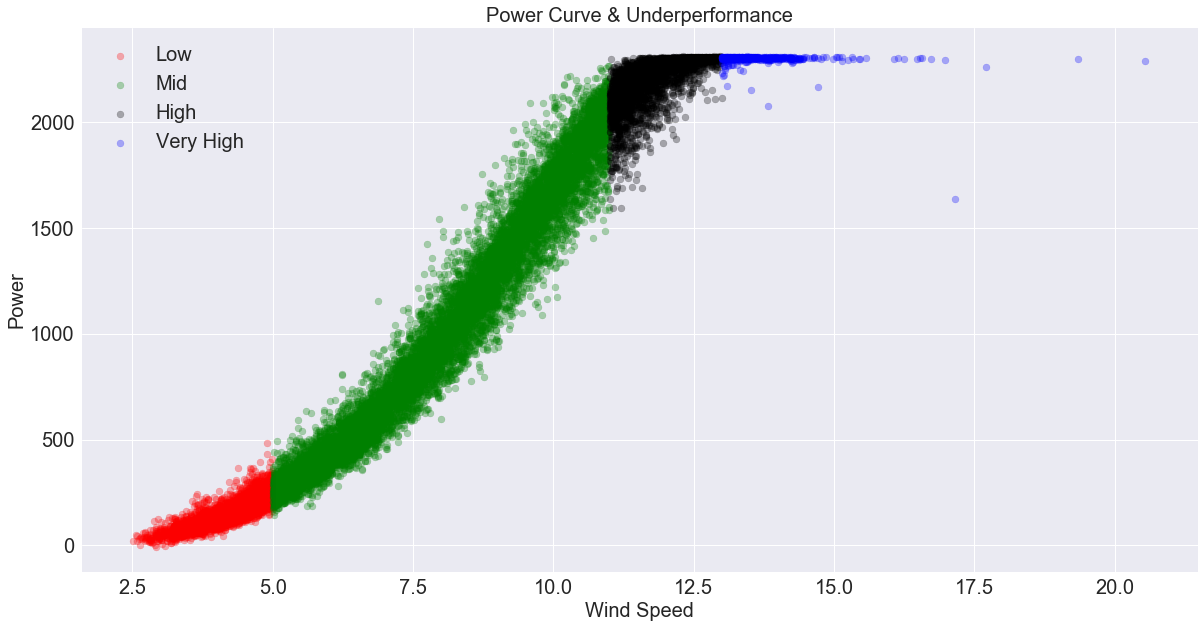

In [57]:
import matplotlib

x1 = df_clean_low['wtc_AcWindSp_mean']
y1 = df_clean_low['wtc_ActPower_mean'] 

x2 = df_clean_mid['wtc_AcWindSp_mean']
y2 = df_clean_mid['wtc_ActPower_mean']

x3 = df_clean_high['wtc_AcWindSp_mean']
y3 = df_clean_high['wtc_ActPower_mean']

x4 = df_clean_veryhigh['wtc_AcWindSp_mean']
y4 = df_clean_veryhigh['wtc_ActPower_mean']

# x4 = df_clean_toohigh['ExpectedEnergy_']
# y4 = df_clean_toohigh['wtc_ActPower_mean']

# c = df['Underperformance']
# labels = ['Blue = Underperformance']

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

plt.scatter(x1, y1,alpha=0.3, label='Low', c='r')
plt.scatter(x2, y2,alpha=0.3,label='Mid', c='g')
plt.scatter(x3, y3,alpha=0.3, label='High', c='k')
plt.scatter(x4, y4,alpha=0.3,label='Very High', c='b')
# plt.axhline(y=2300, color='k')
plt.title("Power Curve & Underperformance")
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.legend()
plt.show()

### Regression

In [128]:
df.dropna(inplace=True)

df_low = df[df['wtc_AcWindSp_mean'] <= low_thresh]

keepcols = ['wtc_AcWindSp_mean',
            'BoostedRef', 
            'wtc_ScInOper_timeon', 
            'Air_density', 
            'Fault_Type', 
            'WS_Thies_80m_Avg', 
            'WS_Thies_60m_Avg', 
            'WS_ICEFREE_Avg', 
            'RH_76m_Avg',
           'BP_mbar_76m_Avg', 
            'AirTC_3m_Avg',
            'Icing',
            'YawError',
            'wtc_NacelPos_mean',
            #'WindSheer1'
           ]

data = df_low[keepcols]

y = df_low["wtc_ActPower_mean"]
X = data

# Normalize response variable
# norm = preprocessing.Normalizer()
# data = norm.transform(data)


#Now the other variables used to train the model need to scaled. First, however, un-need variables need to be dropped.
# y = preprocessing.scale(df_low["wtc_ActPower_mean"])
# X = preprocessing.scale(data) 


### Training and Test Data Creation (80/20 Split)

In [1]:
#  Make test and training data
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train

NameError: name 'train_test_split' is not defined

array([[ 0.42063786,  0.99242673,  0.55678389, ..., -0.08312411,
        -0.43472765,  0.26775053],
       [-1.17199367,  0.99242673, -2.45606121, ..., -0.08312411,
        -0.2040648 , -0.26808867],
       [ 0.63939363, -0.81646953,  0.55678389, ..., -0.08312411,
        -0.2434361 , -0.25539686],
       ..., 
       [ 1.03473439, -0.38075926,  0.55678389, ..., -0.08312411,
        -0.2202676 , -0.26300892],
       [-1.48087063,  0.99242673, -2.45606121, ..., -0.08312411,
        -3.77176017, -1.42633388],
       [ 0.99727016,  0.40555168,  0.55678389, ..., -0.08312411,
        -0.23367332, -0.27955009]])

In [143]:
# Linear Regression
from sklearn import linear_model

# # Set the parameters by cross-validation
# clist = [0.1, 1, 10, 100]
# tuned_parameters = [#{'kernel': ['rbf'], 'C': clist},
#                     {'kernel': ['linear'], 'C': clist}
# #                     {'kernel': ['poly'], 'C': clist},
# #                     {'kernel': ['sigmoid'], 'C': clist}
#                    ]

# alphas = 10.0**-np.arange(1,7)
# tp = [{'alpha':alphas, 'learning_rate':['constant', 'optimal', 'invscaling'], 'eta0': [0.01, 0.1, 0.5, 1.0]}]

# clf = GridSearchCV(svm.SVC(), tuned_parameters)

clf = linear_model.LinearRegression()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print "r2/variance : ", clf.score(X_test,y_test)
print("Residual sum of squares: %.2f"
              % np.mean((cld.predict(X_test) - y_test) ** 2))

r2/variance :  0.784586179651
Residual sum of squares: 0.22


In [ ]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, ground_truth_data, 
   test_size=0.3,random_state =1 )
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print "r2/variance : ", model.score(X_test,y_test)
print("Residual sum of squares: %.2f"
              % np.mean((model.predict(X_test) - y_test) ** 2))

### Model Creation and Parameter Optimization With Grid Search

Running the SVC classifier within SciKit Learn proved to be to costly computationally. As a result, we proceeded with a differnt SVM Classifier. Specifically, we use the SGDClassifier which utilized stochastic gradient descent and greatly increased training rates.

Since there are many possible parameters that can be put into the classifer, we ran through various alphas (or a penalty term), learning rates, and learning rate schedules to find the strongest possible model based on the input parameters. This was done using a grid search.

http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

## Results
The best SGDClassifer had the following attributes: 'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'optimal'

The resulting model had an accuracy of 86.78 percent. 

## Interpret Support Vectors
<b>[10 points]</b>

<i>
Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.
</i>

### Chosen Support Vector Investigation


Investigation of the support vectors tells us about the hyperplane used to separate the data. Specifically, it shows us which vectors define placement of classes. This knowledge is especially useful when classifying edge cases (i.e., where outlier data may be present) in which items could be misclassified.

However, if we fit a smaller model, using the SVC classifier, to apprehend what the support vectors might be, then, even using this smaller subset of data, the resulting array has a length of 5,584. This much information is not helpful or usable by our team to better understand the model. There are simply too many dimensions involved. This demonstrates the power of SVMs as a classifier, as they can handle high dimensional data and make accuarte predicitons with them where humans would fail or cannot even fathom the problem.

In [22]:
#First I want to create a new model object based on the results of the Grid Search
svm_class = svm.SVC(C=0.1, kernel='linear', gamma='auto')
# svm_class = linear_model.SGDClassifier(alpha= 1e-06, eta0= 0.5, learning_rate= 'invscaling')
svm_class.fit(X_train,y_train)

sv = svm_class.support_vectors_
print("There are " + str(len(sv)) + " support vectors")
for x in sv:
    print(x)
    


There are 2872 support vectors
[ -0.07492406   4.8014413    0.55869749   0.79922086   0.23166755
   0.02660211  -0.59556133  -0.61746188   1.03826014  -1.33961537
  13.3041347    1.42185824]
[-2.53918953 -0.88216214 -1.55046855  0.05604598 -0.46436633 -0.81358094
 -0.64085709 -0.71915284 -0.28782118  0.6981037  -0.0751646  -0.68399346]
[ 0.76006153  2.49771484  0.92774184  0.33711161  0.23166755  0.45021068
  0.2142071   0.42276036  0.15420593 -1.10507529 -0.0751646   0.99615274]
[-1.17521696 -0.65975147  0.28124463  0.26700526  0.23166755  0.57135335
  0.84792034  0.68402174 -0.14047881  0.94660602 -0.0751646  -0.85686542]
[ 0.76006153  0.38805339  1.53239168 -0.079043    0.23166755  0.71985082
  0.47444403  0.69206056 -0.43516355  1.30142635 -0.0751646  -1.21038552]
[-1.40308827 -0.96973556 -1.70312765 -0.96812658 -1.30469993 -1.50722044
 -1.43054156 -1.4000402   0.44889067 -0.17934008 -0.0751646   0.23170439]
[-1.88324568  1.63048258 -1.02417106 -1.59026639  0.23166755 -0.58809926
 

  1.27951196  1.35928193 -0.28782118  0.69041806 -0.0751646  -0.6775959 ]
[ 0.94724154  0.34870607  2.43573624  0.01283447  0.23166755  1.3411955
  1.21114101  1.30702965  0.15420593  0.35481183 -0.0751646  -0.29636271]
[ 0.51754135 -0.52115412  0.49715549  0.22063301  0.23166755  1.15361975
  1.48035163  1.24673857 -1.17187539  1.71901274 -0.0751646  -1.70252664]
[-1.66188498 -0.86716219 -0.10272933 -1.86941314  0.23166755 -0.45132528
 -0.31652239 -0.44261772  0.44889067  0.00639619 -0.0751646   0.06957246]
[-1.43075836 -0.38500686  0.07331603  1.5779386   0.23166755  1.21223717
  1.49744437  1.32310728  0.00686356 -1.16886609 -0.0751646   1.0205403 ]
[-2.18598899  1.73039757 -1.05164357  0.83909993  0.23166755 -0.29579372
 -0.17208876 -0.24446101  1.18560251 -1.93576477 -0.0751646   2.02707194]
[-2.36014778  0.19072631 -1.0661611  -1.8385735   0.23166755 -1.03789028
 -0.97459279 -1.015785    1.03826014 -1.75604891 -0.0751646   1.81793061]
[-1.6032895  -0.18110646 -0.21499496  0.15478

  0.51632124  0.57951719  0.44889067 -1.2964477  -0.0751646   1.24277692]
[ 0.76006153 -0.85783346  1.68191062 -1.74125347  0.23166755 -1.92731197
 -1.85657804 -1.92859207  0.3015483   0.6788896  -0.0751646  -0.53676817]
[-1.29566323 -0.60248508 -1.45534108 -0.47655437 -0.31157841 -1.97068886
 -1.87110686 -1.86307575  1.48028725 -0.3343338  -0.0751646   0.60432304]
[-1.90277751  1.09498617 -1.04370406 -0.7842647   0.23166755 -0.91674761
 -0.62974681 -0.82606904  1.92231436 -1.15349482 -0.0751646   1.45484262]
[-2.66289109 -1.50359065 -1.27601679 -1.69236334  0.23166755 -0.9624692
 -0.38959385 -0.77864005  1.03826014 -1.14721821 -0.0751646   1.24200598]
[ 0.76006153  0.3378622   1.49774815 -0.00630799  0.23166755  1.1340806
  0.96329632  1.13821461 -0.43516355  1.07470001 -0.0751646  -1.02674326]
[ 0.94724154  1.22172279  1.97864273  0.1533853   0.23166755  0.7589291
  0.47572599  0.71617699 -0.58250592 -0.20111606 -0.0751646   0.01563081]
[ 0.94724154 -0.64325286  2.0752858   0.2468420

  0.07703789  0.28368892 -1.31921776 -0.01537978 -0.0751646  -0.31264354]
[-1.06453661  1.73633458  0.66592718  0.11558477  0.23166755  0.47365765
  0.10438627  0.41070215 -1.31921776 -0.1639688  -0.0751646  -0.18454908]
[-0.90990965 -0.5782291   1.60426745 -0.34818222  0.23166755  1.13017278
  1.26241923  1.18644748 -1.76124487  1.49100545 -0.0751646  -1.6512368 ]
[ 0.519169   -0.44162734  1.88888983 -0.00672667  0.23166755  2.03288108
  2.29225666  2.13502726 -0.72984829  0.81979298 -0.0751646  -0.88298819]
[ 0.76006153  1.61263205  0.44872558 -0.54983736  0.23166755 -0.01716557
 -0.25327927 -0.06680327  2.06965673 -1.27556838 -0.0751646   1.60410349]
[ 0.37756326  1.04103061  0.85000536 -0.1486957   0.23166755  0.42676371
  0.25095649  0.43481858  0.89091778  0.8428499  -0.0751646  -0.54268573]
[ 0.40035039 -1.95415075  0.16411675 -1.12398767  0.23166755 -1.77178041
 -1.22158284 -1.59538332  1.03826014 -1.62974824 -0.0751646   1.69681019]
[-1.39983297  1.01357892  0.02314055  1.3630

## Logistic Regression

For the Logistics Regression model, we begin by further sizing down our dataset. 

Next, we use scikit-learn to perform logistic regression on our testing and training sets in order to determine which variables impact our response variable. 
We created a function using x_train and y_train from our dataset to test for x_test.  
The accuracy of the regression prediction was compared with that of that original. 
A confustion matrix was produced to reflect an accuracy percentage, demonstrating almost 90%!

In [23]:
#Encode the labels (examples found on SKLearn website... need to find address)
le = preprocessing.LabelEncoder()
le.fit(list(df["Underperformance"].unique()))
df["target"] = le.transform(df["Underperformance"])

#Now the other variables used to train the model need to scaled. First, however, un-need variables need to be dropped.
y = df["target"]

keepcols = ['BoostedRef', 'WindSheer1', 'wtc_AcWindSp_mean', 'wtc_NacelPos_mean',
       'wtc_ScInOper_timeon', 'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg',
       'WS_ICEFREE_Avg', 'BP_mbar_76m_Avg', 'AirTC_3m_Avg', 'Icing',
       'Air_density']
df3 = df[keepcols]
X = preprocessing.scale(df3) 

In [24]:
#  Make test and training data
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr_clf = LogisticRegression(C=1.0, class_weight=None)

from sklearn.model_selection import ShuffleSplit
    
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)      

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
   
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)   

====Iteration 0  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 1  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 2  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 3  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 4  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 5  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 6  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 7  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 8  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
====Iteration 9  ====
accuracy 0.891185647426
confusion matrix
 [[2100   17]
 [ 262  185]]
[ 0.88884555  0.89586583  0.8798752   0.88728549  0.88533541  0.88572543
  0.87948518  0.8

<a id="Feature Importances"></a>
<a href="#top">Back to Top</a>
## Feature Importance

<b>[30 points]</b>

<i>
Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?
</i>

Next, we applied weights to each feature to determine the importance of each attribute as it pertains to predicting turbine performance.  

A detailed list of the features and their weights are listed below.  We will discuss them in greater detail, along with a visualization in the next section.

In [25]:
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df3.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

BoostedRef has weight of -0.971551954442
WindSheer1 has weight of 0.831580718782
wtc_AcWindSp_mean has weight of 1.41899311134
wtc_NacelPos_mean has weight of -0.349011041266
wtc_ScInOper_timeon has weight of -2.61643050384
WS_Thies_80m_Avg has weight of -1.68657011775
WS_Thies_60m_Avg has weight of 2.45846113455
WS_ICEFREE_Avg has weight of -0.707164686277
BP_mbar_76m_Avg has weight of -0.871161641589
AirTC_3m_Avg has weight of 3.01695863176
Icing has weight of -0.147021100074
Air_density has weight of 3.18684988864


### Power Curve Variations
Given the figure below, the feature weights make a lot of sense in predicting turbine performance. 
1. Air Density (Air_Denisty)
    * Air density determines how much force a given volume of air will exert on the turbine blades. 
2. Air Temperature (AirTC_3m_Avg)
    * This feature can correlate with other weather events such as turbulence and storms.
3. Wind Speed (WS_Thies_60m_Avg, wtc_AcWindSp_mean, WS_Thies_80m_Avg)
    * Obviously this is an important factor in determining proper performance.
4. Barometric Pressure (BP_mbar_76m_Avg)
    * This is another feature that can correlate with storms and other weather.
5. Boosted Reference Set Point (BoostedRef)
    * This is an important factor since low turbine performance may be due to a commanded reduction in set point by the electrical grid. Without this factor, there could be a lot of false positives. This feature also has the boosted value incorporated into it to account for times when the turbine is allowed to exceed its nameplate capacity.
6. In-Operation Time (wtc_ScInOper_timeon)
    * This feature is similar to the reference set point in that we would see more false positives without this feature. When a turbine is faulted, it is shut down. This counter gives the amount of seconds in the ten minute window the turbine was running. 
7. Features Removed
    * There were many columns that were thought to be important that did not have large weights in the model. These include: YawError and turbulence.

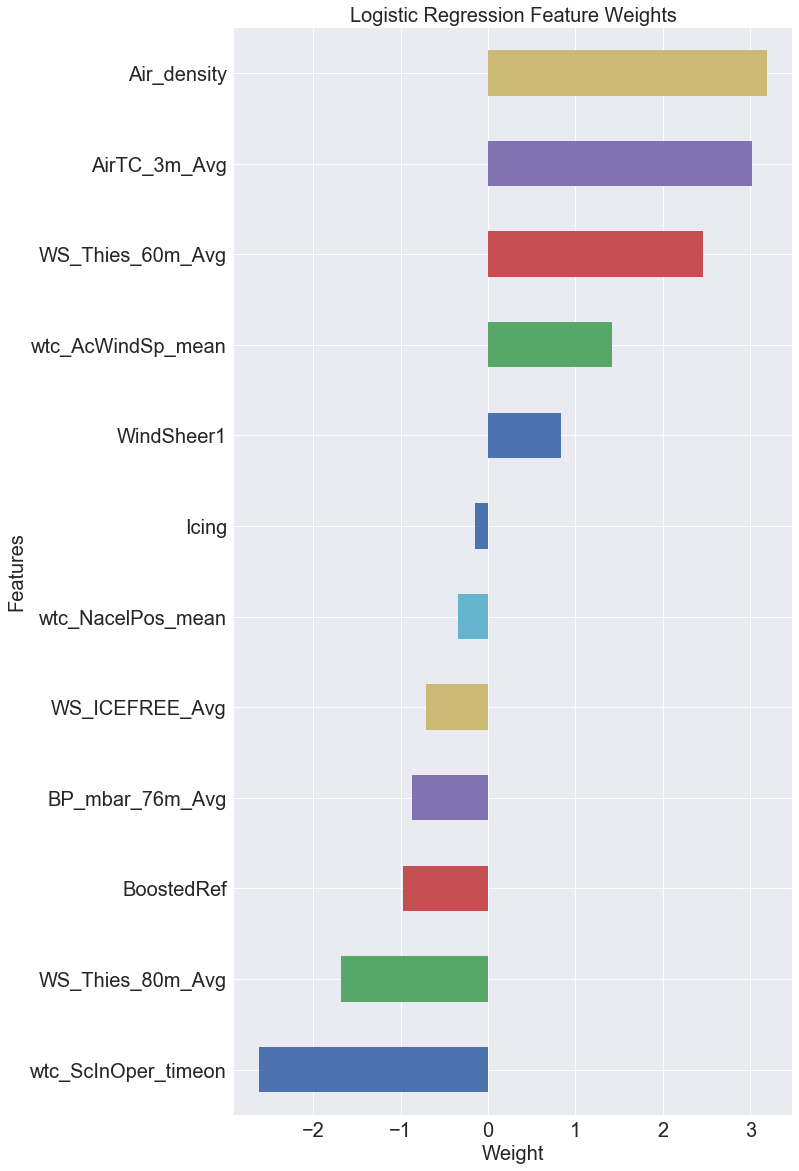

In [27]:
# Plot shows features and their weights

weights = pd.Series(lr_clf.coef_[0],index=df3.columns)
weights.sort_values(inplace=True)

plt.figure(figsize=(10, 20))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

weights.plot(kind='barh')

plt.title("Logistic Regression Feature Weights")
plt.xlabel('Weight')
plt.ylabel('Features')
#plt.legend()
plt.show()

<a id="Model Advantages"></a>
<a href="#top">Back to Top</a>
## Model Advantages

<b>[10 points]</b>

<i>
Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.
</i>

By comparison of accuracy, there was little difference between SVM and logistic regression with accuracies of 87% and 89%, respectively. As the accuracy is so similar, we ultimatley believe that logistic regression is the best method for our dataset, as with compared to SVM with gradient based optimization (SGD). Because our accuracies were so similar, the primary reason for this decision was model interpretability and processing speed if applied at scale.

A key factor in choosing the logistic model was that we could easily explain the weights of the logstic model to stake holders (or anyone else that was interested in the model). In theory, we could use the decision boundry from the SVM model to explain how classes were categorized. However, our decision space was quite large an interpresting the support vectors was difficult. Since both models preformed at similar levels, we opeted for the model that we could easily explain to others.

Another deciding factor was the amount of time it took to train the models. The non SGD SVM took a significant amount of time to train our model, especially when using cross validation. This processing time was decreased dramatically by using stochasitc gradient descent. For example, SGD, SVM ran for an hour without producing any results.  With SGD, we had results within minutes. In fact, we were not able to fully train a SVM model on our computers without SGD, let alone compare many different models.  However, even wiht gradient optimization, logistic regression was still the most efficient option.  And, we've noted that our analysis would be most effective is trained at least 12 months of data, in order to capture all possible environmental conditions. Given that one quarter of data (our current dataset) contains 1,048,576 observations, going forward its essential that we have the most efficient process possible, as our dataset will be exponentially larger.

While, we do believe that logistics regression serves our current dataset best, we did recognize a few key advantages to SVM.  We noted that SVM can be altered to support several different classes, while logistics regression can only fit two.  In addition, SVM can support non-lineral data and robust to outliers.  Finally, SVM has more options for controlling model output (i.e. kernel, penalty terms (C), gamma) which can allow a log of flexability in the modelling process.  We did not note the same benefit for logistic regression.

### Conclusion
In the end we were able to properly classify almost 90% of the underperformance occurances for this turbine (shown in the scatter plot below).  The variables related to air density, air temperature, wind speed, barometric pressure, boosted reference set point, and in-operation time were important in predicting performance.  As four of those variables are specifically releated to weather, we note that future analysis should include at least 12 months of observations, rather than the one quarter we currently analyzed, as weather is a critical variable in turbine performance which has a seasonal component.

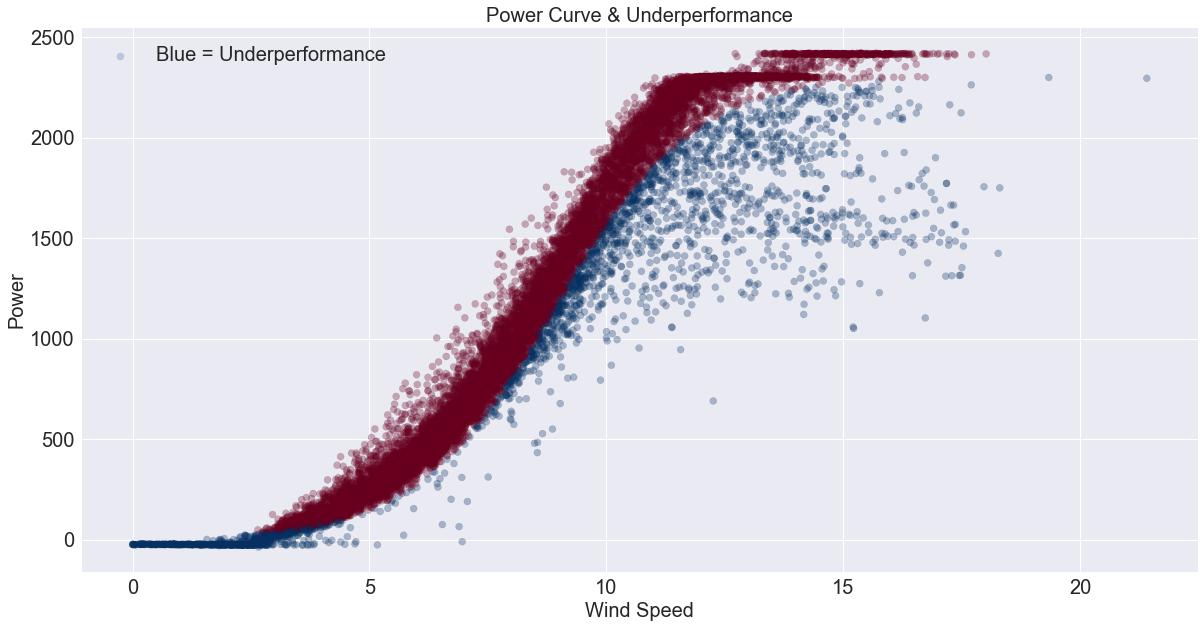

In [34]:
import matplotlib
x2 = df['wtc_AcWindSp_mean']
y2 = df['wtc_ActPower_mean'] 
c = df['Underperformance']
labels = ['Blue = Underperformance']

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

# plt.scatter(x1, y1,alpha=0.3, label='Median', c='r')
plt.scatter(x2, y2,alpha=0.3,c=c, cmap=pylab.cm.RdBu)
# plt.scatter(x3, y3,alpha=0.3, label='Reference', c='k')
# plt.axhline(y=2300, color='k')
plt.title("Power Curve & Underperformance")
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.legend(labels)
plt.show()

## Linear Regression

In [67]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

In [69]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               } 

In [103]:
np.any(np.isnan(df))
np.all(np.isfinite(df))

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [111]:

df.dropna(inplace=True)

df_low = df[df['wtc_AcWindSp_mean'] <= low_thresh]

keepcols = ['wtc_AcWindSp_mean',
            'BoostedRef', 
            'wtc_ScInOper_timeon', 
            'Air_density', 
            'Fault_Type', 
            'WS_Thies_80m_Avg', 
            'WS_Thies_60m_Avg', 
            'WS_ICEFREE_Avg', 
            'RH_76m_Avg',
           'BP_mbar_76m_Avg', 
            'AirTC_3m_Avg',
            'Icing',
            'YawError',
            'wtc_NacelPos_mean',
            #'WindSheer1'
           ]

x = df_low[keepcols]
y = df_low["wtc_ActPower_mean"]

In [110]:
np.isfinite(x.sum())

wtc_AcWindSp_mean       True
BoostedRef              True
wtc_ScInOper_timeon     True
Air_density             True
WS_Thies_80m_Avg        True
WS_Thies_60m_Avg        True
WS_ICEFREE_Avg          True
RH_76m_Avg              True
BP_mbar_76m_Avg         True
AirTC_3m_Avg            True
YawError                True
wtc_NacelPos_mean       True
WindSheer1             False
dtype: bool

In [112]:
from sklearn.cross_validation  import KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

poly = PolynomialFeatures(degree=2)
x_train_ = poly.fit_transform(x_train)
x_test_ = poly.fit_transform(x_test)

# Instantiate
lg = LinearRegression()

# Fit
lg.fit(x_train_, y_train)

# Obtain coefficients
c_low = lg.coef_

# Predict
pred_train = lg.predict(x_train_)
lg.score(x_test_,y_test)

0.7648460724284819

In [116]:
# Compute RMSE on training data

df['ExpectedEnergy_low'] = lg.predict(x)

df['Residual'] = x - y #df['ExpectedEnergy_low'] - df['wtc_ActPower_mean']
# Let's see the error on the first 10 predictions
# err[:10]
df[['ExpectedEnergy_low','Residual']].head()

ValueError: shapes (9035,14) and (120,) not aligned: 14 (dim 1) != 120 (dim 0)